# MolDrug without receptor

One of the strengths of MolDrug is the ability to optimize on the chemical space based on docking results. However it could also be used to optimize some QSAR function when the information of the receptor is not available. Some previous of this application where show [here](https://moldrug.readthedocs.io/en/latest/notebooks/how_to.html#Create-your-own-cost-function).

## Imports and creating working directory

In [5]:
from moldrug import utils
from rdkit import Chem
from rdkit.Chem import Lipinski, Draw
import multiprocessing as mp
import shutil, os, gzip, requests, tempfile

In [6]:
# Remember to change to your vina executable
# If you define as a path, it must be absolute
vina_executable = '/Users/klimt/GIT/docking/bin/vina'

In [7]:
# Defining the wd and change directory
wd = 'wd'
os.mkdir(wd)
os.chdir(wd)

## Getting the CReM data base

In [8]:
url = "http://www.qsar4u.com/files/cremdb/replacements02_sc2.db.gz"
r = requests.get(url, allow_redirects=True)
crem_dbgz_path = 'crem.db.gz'
crem_db_path = 'crem.db'
open(crem_dbgz_path, 'wb').write(r.content)
with gzip.open(crem_dbgz_path, 'rb') as f_in:
    with open(crem_db_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

## Define the function
Let's assume that our QSAR model give us that the best molecules are those ones that have more hydrogen bonds acceptor and donors. Because MolDrug minimize we must use the negative of this number.

In [9]:
def QSAR_model_cost(Individual:utils.Individual) -> utils.Individual:
    """Simple cost function

    Parameters
    ----------
    Individual : utils.Individual
        An initialize Individual

    Returns
    -------
    utils.Individual
        The individual with cost sum of HBA and HBD with negative sign
    """
    NumHAcceptors  = Lipinski.NumHAcceptors(Individual.mol)
    NumHDonors = Lipinski.NumHDonors(Individual.mol)
    model = NumHAcceptors + NumHDonors
    Individual.cost = -model
    return Individual


## Set MolDrug run

The next code is a duplication for the implementation of `QSAR_model_cost` fitness function.
Is written in this way due to some possible problems that might arise because the execution of multiprocessing inside `GA` on an interactive Python like IPython-Notebook.

For that we will create the python script and to be able to executed it inside the NoteBook.


In [24]:
script = """

from rdkit.Chem import  Lipinski

from rdkit import Chem
from moldrug import utils
import multiprocessing as mp

def QSAR_model_cost(Individual):
    NumHAcceptors  = Lipinski.NumHAcceptors(Individual.mol)
    NumHDonors = Lipinski.NumHDonors(Individual.mol)
    model = NumHAcceptors + NumHDonors
    Individual.cost = -model
    return Individual

if __name__ == "__main__":
    ga = utils.GA(
        Chem.MolFromSmiles('CCCC'),
        crem_db_path='crem.db',
        maxiter=10,
        popsize=50,
        costfunc=QSAR_model_cost,
        mutate_crem_kwargs={
            'ncores': mp.cpu_count()
        },
        costfunc_kwargs={},
        randomseed=1234,)

    ga(12)
    ga.pickle(title='ga', compress = True)
"""
with open('script.py', 'w') as f:
    f.write(script)

In [25]:
! python script.py



Creating the first population with 50 members:
100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 31.04it/s]
Initial Population: Best Individual: Individual(idx = 31, smiles = CS(=O)(=O)NO, cost = -5)
Accepted rate: 50 / 50

Evaluating generation 1 / 10:
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 32.38it/s]
Generation 1: Best Individual: Individual(idx = 31, smiles = CS(=O)(=O)NO, cost = -5).
Accepted rate: 23 / 49

Evaluating generation 2 / 10:
100%|███████████████████████████████████████████| 47/47 [00:01<00:00, 29.40it/s]
Generation 2: Best Individual: Individual(idx = 114, smiles = N=C(NO)c1ccncc1, cost = -6).
Accepted rate: 13 / 47

Evaluating generation 3 / 10:
100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 27.39it/s]
Generation 3: Best Individual: Individual(idx = 114, smiles = N=C(NO)c1ccncc1, cost = -6).
Accepted rate: 19 / 49

Evaluating generation 4 / 10:
100%|███████████████████████████████████████████| 

In [26]:
ga = utils.decompress_pickle('ga.pbz2')

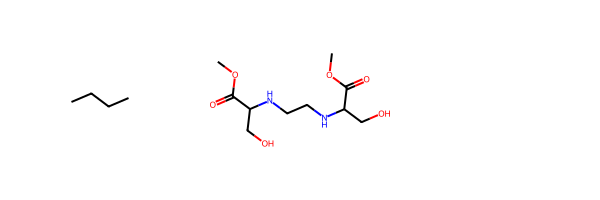

In [27]:
Draw.MolsToGridImage([ga.InitIndividual.mol, ga.pop[0].mol])

As you can see, this simulation is really good: On every single carbon atom it is bound, at least, one HBD and/or HBA!

[Text(0.5, 1.0, 'best_cost')]

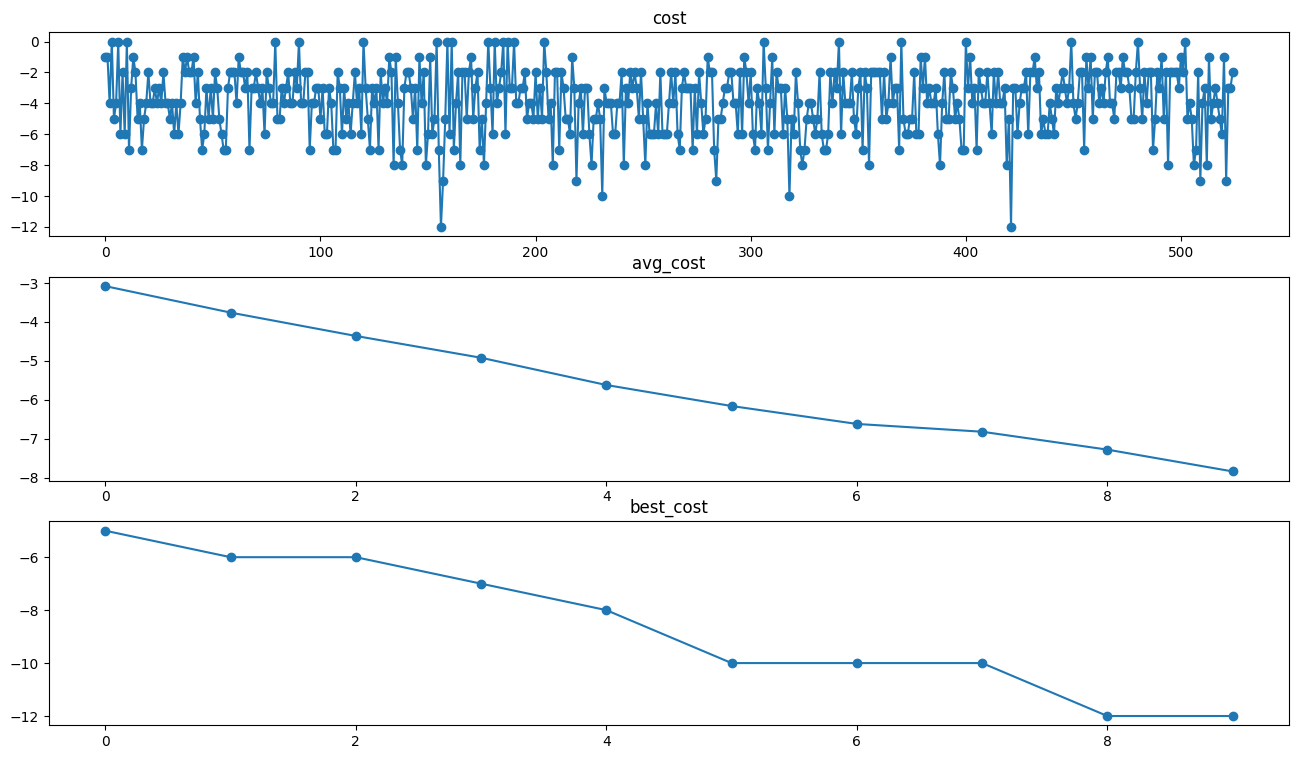

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3,  figsize = (16,9))
ax[0].plot([individual.cost for individual in ga.SawIndividuals], '-o')
ax[0].set(title = 'cost')
ax[1].plot([cost for cost in ga.avg_cost], '-o')
ax[1].set(title = 'avg_cost')
ax[2].plot([cost for cost in ga.best_cost], '-o')
ax[2].set(title = 'best_cost')